# 1. Install Dependencies

In [2]:
#%pip install gymnasium
#%pip install 'gymnasium[atari]'
#%pip install 'gymnasium[accept-rom-license]'
#%pip install 'shimmy>=0.2.1'
#%pip install torch torchvision torchaudio
#%pip install matplotlib
#%pip install tensorboard
#%pip install 'stable-baselines3[extra]>=2.0.0a4'
#%pip install scikit-image

# 2. Import Dependencies

In [3]:
import gymnasium
from gymnasium import spaces
from gymnasium.spaces import Box

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output

import time
import numpy as np
from skimage.transform import resize

import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Module

from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [4]:
# Change to True if you want to run on Kaggle
# Also, the underground model should be uploaded to Kaggle
KAGGLE = False

# 3. Utils

In [5]:
class UndergroundModel(Module):
    def __init__(self):
        super(UndergroundModel, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=10, stride=1, padding=2)
        self.conv2 = Conv2d(16, 32, kernel_size=10, stride=1, padding=1)
        self.conv3 = Conv2d(32, 64, kernel_size=7, stride=1, padding=1)
        self.fc1 = Linear(7744, 16)
        self.fc2 = Linear(16, 16)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.relu = ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [6]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        #print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        print(f"Comulative Reward: {experience['com_reward']}")
        
        # Pause animation
        time.sleep(time_lag)

In [7]:
def store_episode_as_gif(experience_buffer, filepath='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(filepath, writer='imagemagick', fps=fps)

# 4. Create Base Environment

In [8]:
base_env = gymnasium.make('ALE/Pitfall-ram-v5', render_mode='rgb_array')
if base_env.reset():
    print('Environment is ready!')

Environment is ready!


State space: Box(0, 255, (128,), uint8)
Action space: Discrete(18)
Action space: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Action: 9
Reward: 0.0
State done :False
State info :{'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


a:\Anaconda\envs\ap\lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


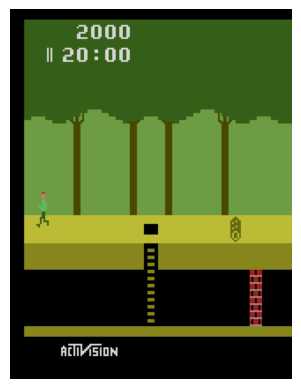

In [9]:
def show_env_info(env):
    # Print dimensions of state and action space
    print("State space: {}".format(base_env.observation_space))
    print(f"Action space: {env.action_space}")
    print(f"Action space: {env.unwrapped.get_action_meanings()}")

    # Sample random action
    action =env.action_space.sample()
    print("Action: {}".format(action))
    next_state, reward, done, _, info = env.step(action)

    # Print output
    print("Reward: {}".format(reward))
    print(f"State done :{done}")
    print(f"State info :{info}")

    # Render and plot an environment frame
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

show_env_info(base_env)

# 5. Customize Environment

In [10]:
model_path = 'models/model.h5'
if KAGGLE:
    model_path = '/kaggle/input/' + model_path

underground_model = UndergroundModel()
underground_model.load_state_dict(torch.load(model_path))
underground_model.eval()

UndergroundModel(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7744, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [11]:
#class CustomEnv(gymnasium.Wrapper):
#
#    def __init__(self, env, model):
#        super(CustomEnv, self).__init__(env)
#        self.env = env
#        self.model = model
#        self.lives = 3
#        self.last_room = None
#        self.is_zero_before = False
#        self.n_zeros_before = 0
#        self.observation_space = Box(shape=(130,130,3), low=int(0), high=int(255))
#        self.latest_visited_room = 196 # id of first room
#        self.steps_in_same_room = 0
#        self.visited_rooms = [196]
#        self.left_moving_action = [4] #, 7, 9, 12, 15, 17] # all the left actions...
#        
#    def calculate_mse(self, img1, img2):
#        np_image1 = np.array(img1)
#        np_image2 = np.array(img2)
#        mse = np.mean((np_image1 - np_image2) ** 2)
#        return mse
#
#    def step(self, action):
#        next_state_ram, reward, done, truncated, info = self.env.step(action)
#        self.lives = info['lives']
#
#        next_state_img = self.env.render()
#        next_state_img = resize(next_state_img,(130,130))
#        underground_prediction = self.make_underground_prediction(next_state_img)
#        if underground_prediction == 1:
#            reward -= 3
#        
#        # Reward if agent discovers a new room
#        current_room_id = next_state_ram[1]
#        # Note: Rewarding changing rooms induced the agent to change rooms forever
#        #if current_room_id != self.latest_visited_room:
#        #    reward += 3
#        # Penalize for staying in the same room to much time (~100 steps)
#        if current_room_id == self.latest_visited_room:
#            self.steps_in_same_room += 1
#            if self.steps_in_same_room > 100:
#                reward -= 50
#                self.steps_in_same_room = 0
#        else:
#            self.steps_in_same_room = 0
#        
#        if current_room_id not in self.visited_rooms:
#            reward += 200
#            self.visited_rooms.append(current_room_id)
#        
#        self.latest_visited_room = current_room_id
#        
#        # Rewarding left movement
#        if action in self.left_moving_action:
#            reward += 5
#
#        # Try to detect death ASAP
#        mse_score = None
#        if self.last_room is not None:
#            mse_score = self.calculate_mse(self.last_room, next_state_img)
#            if mse_score == 0:
#                if self.is_zero_before and self.n_zeros_before > 5:
#                    reward -= 1000
#                    self.n_zeros_before = -9999
#                
#                self.is_zero_before = True
#                self.n_zeros_before += 1
#                
#            else:
#                self.is_zero_before = False
#                self.n_zeros_before = 0
#        
#        self.last_room = next_state_img
#        return next_state_img, reward, done, truncated, info
#
#    def reset(self,seed=None):
#        if seed:
#            _,info = self.env.reset(seed=seed)
#        else:
#            _,info = self.env.reset()
#        img = self.env.render()
#        img = resize(img,(130,130))
#        return (img,info)
#        
#
#    def make_underground_prediction(self, img):
#        '''Checks if player is underground'''
#        img = self.preprocessar(img)
#        img = img.astype(np.float32)
#        img = Tensor(img)
#        img = img.reshape(1,3,130,130)
#        pred = self.model(img)
#        pred = pred.detach().cpu().detach().numpy()[0].argmax()
#        return pred
#
#    def preprocessar(self,imagem):
#        imagem = np.array(imagem)
#        data_mean = np.mean(imagem)
#        data_std = np.std(imagem)
#        imagem = (imagem - data_mean) / data_std
#        xmax, xmin = imagem.max(), imagem.min()
#        imagem = (imagem - xmin)/(xmax - xmin)
#        imagem = imagem.transpose(2,1,0)
#        return imagem
#
#env = CustomEnv(base_env, underground_model)
#if env.reset():
#    print('Custom Environment is ready!')

# 5.1 Normalized Rewards without bonus for left or right

Available actions: 'NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'

'RIGHT' = 'UPRIGHT' \
'LEFT' = 'UPLEFT' \
'FIRE' = 'UPFIRE', 'DOWNFIRE' \
'RIGHTFIRE' = 'UPRIGHTFIRE', 'DOWNRIGHTFIRE' \
'LEFTFIRE' = 'UPLEFTFIRE', 'DOWNLEFTFIRE' 
 
Redundant actions: 'UPRIGHT', 'UPLEFT', 'UPFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'DOWNRIGHTFIRE', 'UPLEFTFIRE', 'DOWNLEFTFIRE'

In [12]:
# The reward values will be between [-1,1]

class CustomEnv2(gymnasium.Wrapper):

    def __init__(self, env, model):
        super(CustomEnv2, self).__init__(env)
        self.env = env
        self.model = model
        self.lives = 3
        self.last_room = None
        self.is_zero_before = False
        self.n_zeros_before = 0
        self.observation_space = Box(shape=(130,130,3), low=int(0), high=int(255))
        self.latest_visited_room = 196 # id of first room
        self.steps_in_same_room = 0
        self.visited_rooms = [196]
        #self.left_moving_action = [4] #, 7, 9, 12, 15, 17] # all the left actions...
        self.env.action_space = gymnasium.spaces.Discrete(10)
        
    def calculate_mse(self, img1, img2):
        np_image1 = np.array(img1)
        np_image2 = np.array(img2)
        mse = np.mean((np_image1 - np_image2) ** 2)
        return mse
    
    #def wrapp_actions(self,action):
    #    match action:
    #        case 6:
    #            action = 3
    #        case 7:
    #            action = 4
    #        case 10:
    #            action = 1
    #        case 13:
    #            action = 1
    #        case 14:
    #            action = 11
    #        case 16:
    #            action = 11
    #        case 15:
    #            action = 12
    #        case 17:
    #            action = 12
    #        case _:
    #            pass
    #    return action

    def map_actions(self,action):
        match action:
            case 6:
                action = 11
            case 7:
                action = 12
            case _:
                pass
        return action

    def step(self, action):
        action = self.map_actions(action)
        next_state_ram, reward, done, truncated, info = self.env.step(action)
        self.lives = info['lives']

        # Normalizing the reward for every treasure to be worth the same
        if(reward>0):
            if(reward>2000):
                reward = 2000
            reward = reward/2000

        # Normalizing the biggest score penalty
        elif(reward<0):
            if(reward<-100):
                reward = -100
            reward = reward/100    

        next_state_img = self.env.render()
        next_state_img = resize(next_state_img,(130,130))
        underground_prediction = self.make_underground_prediction(next_state_img)
        if underground_prediction == 1:
            reward -= 0.25
        
        #if (next_state_ram[1] != 196):
        #    print(next_state_ram[1])

        # Reward if agent discovers a new room
        current_room_id = next_state_ram[1]
        # Note: Rewarding changing rooms induced the agent to change rooms forever
        #if current_room_id != self.latest_visited_room:
        #    reward += 3
        # Penalize for staying in the same room to much time (~100 steps)
        if current_room_id == self.latest_visited_room:
            self.steps_in_same_room += 1
            if self.steps_in_same_room > 100:
                reward -= (0.01 + (self.steps_in_same_room-100)*0.005)
                #self.steps_in_same_room = 0
        else:
            self.steps_in_same_room = 0
        
        if current_room_id not in self.visited_rooms:
            #print("ROOM ID: {}".format(current_room_id))
            #print("VISITED ROOMS BEFORE: {}".format(self.visited_rooms))
            #print("REWARD VALUE BEFORE: {}".format(reward))
            reward += 0.75
            #print("REWARD VALUE AFTER: {}".format(reward))
            self.visited_rooms.append(current_room_id)
            #print("VISITED ROOMS AFTER: {}".format(self.visited_rooms))
            
        
        self.latest_visited_room = current_room_id
        
        # Rewarding left movement
        #if action in self.left_moving_action:
        #    reward += 0.05

        # Try to detect death ASAP
        mse_score = None
        if self.last_room is not None:
            mse_score = self.calculate_mse(self.last_room, next_state_img)
            if mse_score == 0:
                if self.is_zero_before and self.n_zeros_before > 5:
                    reward -= 1
                    self.n_zeros_before = -9999
                
                self.is_zero_before = True
                self.n_zeros_before += 1
                
            else:
                self.is_zero_before = False
                self.n_zeros_before = 0

        if(reward>1):
            reward = 1

        elif(reward<-1):
            reward = -1

        #print("REWARD VALUE IN THE END: {}".format(reward))
        
        self.last_room = next_state_img
        return next_state_img, reward, done, truncated, info

    def reset(self,seed=None):
        if seed:
            _,info = self.env.reset(seed=seed)
        else:
            _,info = self.env.reset()
        img = self.env.render()
        img = resize(img,(130,130))
        return (img,info)
        

    def make_underground_prediction(self, img):
        '''Checks if player is underground'''
        img = self.preprocessar(img)
        img = img.astype(np.float32)
        img = Tensor(img)
        img = img.reshape(1,3,130,130)
        pred = self.model(img)
        pred = pred.detach().cpu().detach().numpy()[0].argmax()
        return pred

    def preprocessar(self,imagem):
        imagem = np.array(imagem)
        data_mean = np.mean(imagem)
        data_std = np.std(imagem)
        imagem = (imagem - data_mean) / data_std
        xmax, xmin = imagem.max(), imagem.min()
        imagem = (imagem - xmin)/(xmax - xmin)
        imagem = imagem.transpose(2,1,0)
        return imagem

env = CustomEnv2(base_env, underground_model)
if env.reset():
    print('Custom Environment is ready!')

Custom Environment is ready!


# 6. Custom Model: Define and Train

In [13]:
# Print action space and number of actions
n_actions = env.action_space.n
actions = env.unwrapped.get_action_meanings()
print(f"Number of actions: {n_actions}, Actions: {actions}")

Number of actions: 10, Actions: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [14]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Flatten(),
        )
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]


        self.linear = torch.nn.Sequential(
            torch.nn.Linear(n_flatten, features_dim),
            torch.nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))


In [15]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
class TensorboardCallback(BaseCallback):
    def __init__(self, log_dir, save_freq, save_path, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.writer = SummaryWriter(log_dir=log_dir)
        self.save_freq = save_freq
        self.save_path = save_path

    def _on_step(self) -> bool:
        # Log training metrics
        self.writer.add_scalar("Loss", self.locals["values"].item(), self.num_timesteps)
        self.writer.add_scalar("Reward", self.locals["rewards"][0], self.num_timesteps)

        # Save model every `self.save_freq` steps
        if self.num_timesteps % self.save_freq == 0:
            self.model.save(self.save_path+f"_{self.num_timesteps}")

        return True

    def _on_training_end(self) -> None:
        # Close the SummaryWriter after training
        self.writer.close()

# Specify the log directory where TensorBoard files will be saved
log_dir = "logs/"

# Create a TensorboardCallback
tensorboard_callback = TensorboardCallback(log_dir=log_dir, save_freq=10000, save_path='(kaggle) ppo_pitfall_1M')

In [ ]:
# Train the agent
#model.learn(total_timesteps=20000, callback=tensorboard_callback)

# Save the model
#model.save("(kaggle) ppo_pitfall_1M_final")

# 7. Test Model

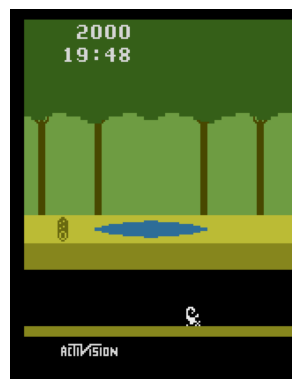

Episode: 1004/1004
Epoch: 1/1
Action: 4
Reward: 0.0
Comulative Reward: 0.25


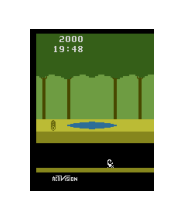

In [38]:
# Reseting the environment between tests
env = CustomEnv2(base_env, underground_model)

# Loading the model
model = PPO.load("models_kaggle_norm_rewards_without_bonus_left_or_right\ppo_pitfall_1M_200000")

experience_buffer = []
obs = env.reset()[0]
com_reward = 0
terminated = False
epoch = 0

start_time = time.time()

while epoch <= 1:
    epoch += 1
    while not terminated:
        action, _ = model.predict(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        com_reward += reward

        experience_buffer.append({
            'episode': info['episode_frame_number'],
            'epoch': epoch,
            'frame': env.render(),
            'action': action,
            'reward': reward,
            'state': obs,
            'com_reward': com_reward,
        })
        
        obs = next_obs
        
        if time.time() - start_time > 30:
            break

run_animation(experience_buffer)
store_episode_as_gif(experience_buffer, filepath='animation.gif')